# Motivating Example: Figure 4

Figure below is the motivating example in this paper: *Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks*. This graph contains one mediator $M_1$ that connects the treatment $X$ to the outcome $Y$.

In [1]:
import eliater
from eliater.frontdoor_backdoor import single_mediator_confounders_nuisance_vars_example as example
from y0.dsl import X, Y

eliater.version_df()

,key,value
0,eliater,0.0.3-dev-d96d4351
1,y0,0.2.9-dev-06df659d
2,Run at,2024-01-28 12:56:44


In [2]:
SEED = 500
treatment = X
outcome = Y

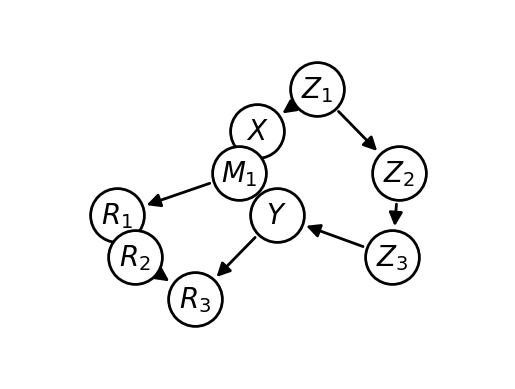

In [3]:
graph = example.graph
graph.draw()

In [4]:
data = example.generate_data(num_samples=1000, seed=SEED)
data.head()

,X,M1,Z1,Z2,Z3,R1,R2,R3,Y
0,1,2.934394,56.979352,22.616432,17.600963,12.276276,5.073340,-2.903520,-2.629445
1,1,2.398253,41.325372,17.927938,17.815860,-2.461589,-3.001966,2.744132,4.287597
2,1,0.170075,47.119159,16.477906,15.465666,-4.784189,-4.581674,-10.634326,1.548849
3,1,2.285580,56.267263,12.351119,11.600543,0.731370,-1.331269,8.751081,26.297357
4,1,-6.300323,69.431847,20.250730,14.255859,-6.614901,-6.511525,0.235470,18.188091


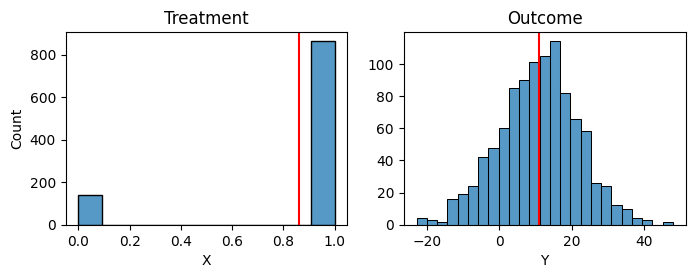

In [5]:
eliater.plot_treatment_and_outcome(data, treatment, outcome)

In [6]:
eliater.step_1_notebook(graph=graph, data=data)

## Step 1: Checking the ADMG Structure

Of the 26 d-separations implied by the network's structure, 10 (38.46%) rejected the null hypothesis with the pearson test at p<0.01.

Since this is more than 30%, Eliater considers this a major inconsistency and therefore suggests adding appropriate bidirected edges using the eliater.add_ci_undirected_edges() function. Finished in 0.25 seconds.


| left   | right   | given   |     stats |           p | dof   |       p_adj | p_adj_significant   |
|:-------|:--------|:--------|----------:|------------:|:------|------------:|:--------------------|
| R3     | Z1      | R2|Y    | -0.302246 | 1.43556e-22 |       | 3.73247e-21 | True                |
| R3     | Z2      | R2|Y    | -0.288145 | 1.42478e-20 |       | 3.56195e-19 | True                |
| R3     | Z3      | R2|Y    | -0.251913 | 6.11502e-16 |       | 1.46761e-14 | True                |
| R3     | X       | R2|Y    | -0.249136 | 1.29673e-15 |       | 2.98248e-14 | True                |
| Z1     | Z3      | Z2      |  0.188419 | 1.91629e-09 |       | 4.21585e-08 | True                |
| R1     | X       | M1      | -0.184472 | 4.18476e-09 |       | 8.78801e-08 | True                |
| X      | Z3      | Z2      |  0.12073  | 0.000129695 |       | 0.0025939   | True                |
| R1     | Z1      | X       | -0.112316 | 0.000372903 |       | 0.00708516  | True                |
| M1     | Z3      | X       |  0.110068 | 0.000488631 |       | 0.00879537  | True                |
| M1     | R3      | R2|Y    | -0.109548 | 0.000519821 |       | 0.00883696  | True                |

In [7]:
eliater.step_1_notebook(graph=graph, data=data, binarize=True)

## Step 1: Checking the ADMG Structure

On this try, we're going to discretize the data using K-Bins discretization with K as 2. Here are the first few rows of the transformed dataframe after doing that:

X,M1,Z1,Z2,Z3,R1,R2,R3,Y
1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


Of the 26 d-separations implied by the network's structure, only 1 (3.85%) rejected the null hypothesis for the cressie_read test at p<0.01.

Since this is less than 30%, Eliater considers this minor and leaves the network unmodified. Finished in 0.23 seconds.


| left   | right   | given   |   stats |           p |   dof |       p_adj | p_adj_significant   |
|:-------|:--------|:--------|--------:|------------:|------:|------------:|:--------------------|
| R1     | R3      | M1|R2   |  26.854 | 2.12763e-05 |     4 | 0.000553184 | True                |

In [8]:
eliater.step_2_notebook(graph=graph, treatment=X, outcome=Y)


## Step 2: Check Query Identifiability

The causal query of interest is the average treatment effect of $X$ on $Y$, defined as: 
$\mathbb{E}[Y \mid do(X=1)] - \mathbb{E}[Y \mid do(X=0)]$.


Running the ID algorithm defined by [Identification of joint interventional distributions in recursive
semi-Markovian causal models](https://dl.acm.org/doi/10.5555/1597348.1597382) (Shpitser and Pearl, 2006)
and implemented in the $Y_0$ Causal Reasoning Engine gives the following estimand:

$\sum\limits_{M_1, Z_1, Z_2, Z_3} P(M_1 | X, Z_1) P(Y | M_1, X, Z_1, Z_2, Z_3) P(Z_2 | Z_1) P(Z_3 | Z_1, Z_2) \sum\limits_{M_1, X, Y, Z_2, Z_3} \sum\limits_{R_1, R_2, R_3} P(M_1, R_1, R_2, R_3, X, Y, Z_1, Z_2, Z_3)$

Because the query is identifiable, we can proceed to Step 3.


## Step 3/4: Identify Nuisance Variables and Simplify the ADMG

The following 3 variables were identified as _nuisance_ variables,
meaning that they appear as descendants of nodes appearing in paths between
the treatment and outcome, but are not themselves ancestors of the outcome variable:

$R_1$, $R_2$, $R_3$

These variables are marked as "latent" in the ADMG and the simplification rules
from [Graphs for margins of Bayesian networks](https://arxiv.org/abs/1408.1809)
(Evans, 2016) are applied to reduce the ADMG using the implementation from the
$Y_0$ Causal Reasoning Engine. The reduced ADMG, which not only excludes the
nuisance variables, but also additionally reasons over bidirected edges,
is shown below.


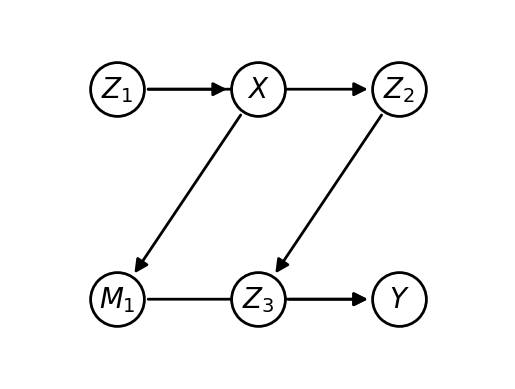

In [9]:
reduced_graph = eliater.step_3_notebook(graph=graph, treatment=X, outcome=Y)

## Step 5: Estimate the Query

### Calculating the True Average Treatment Effect (ATE)

We first generated synthetic observational data. Now, we generate two interventional datasets:
one where we set $X$ to $0.0$ and one where we set $X$ to $1.0$.
We can then calculate the "true" average treatment effect (ATE) as the difference of the means
for the outcome variable $Y$ in each. The ATE is formulated as:

$ATE = \mathbb{E}[Y \mid do(X = 1)] - \mathbb{E}[Y \mid do(X = 0)]$

After generating 10,000 samples for each distribution, we took 500 subsamples of size
of size 1,000 and calculated the
ATE for each. The variance comes to 0.0, which shows that the ATE is very stable with respect
to random generation. We therefore calculate the _true_ ATE as the average value from these samplings,
which comes to 0.0.

The ATE can be interpreted in the following way:

1. If the ATE is positive, it suggests that the treatment $X$ has a negative effect on the outcome $Y$
2. If the ATE is negative, it suggests that the treatment $X$ has a positive effect on the outcome $Y$

**Caveat**: Eliater does not yet implement a notion of confidence for the ATE. For example, it's not clear
where the cutoff for _significance_ is, and whether that is dataset- or ADMG-dependent.

### Estimating the Average Treatment Effect (ATE)

In practice, we are often unable to get the appropriate interventional data, and therefore want to estimate
the average treatment effect (ATE) from observational data. Because we're using synthetic data, we generate
10,000 samples, then took 500 subsamples of size 1,000 through which we calculated
the following:

1. The ATE, using the y0/ananke implementation
2. The ATE, using the Eliater linear regression implementation


Analyzing w/ subsampling:   0%|          | 0/500 [00:00<?, ?sample/s]

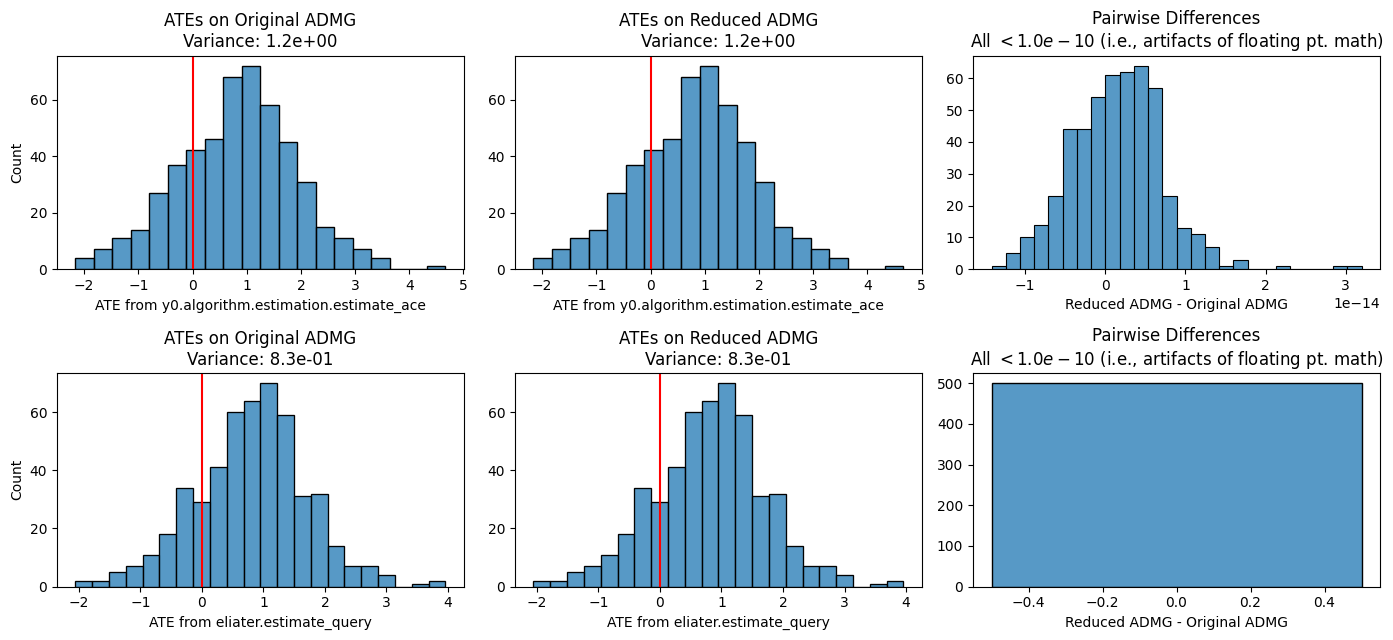

Interpretations:

1. We show the _true_ ATE as a red vertical line
2. We show both this process done with the original ADMG and the reduced ADMG. This shows that the reduction
   on the ADMG does not affect estimation. However, reduction is still valuable for simplifying visual exploration.

**Caveats** Eliater should implement a statistical test to say if the ATE is meaningfully positive or negative
in these case. Further, how does someone without a reference _true_ ATE make an interpretation?

### Estimating the Expected Value

We now estimate the query in the form of the expected value:

$\mathbb{E}[Y \mid do(X = 0)]$


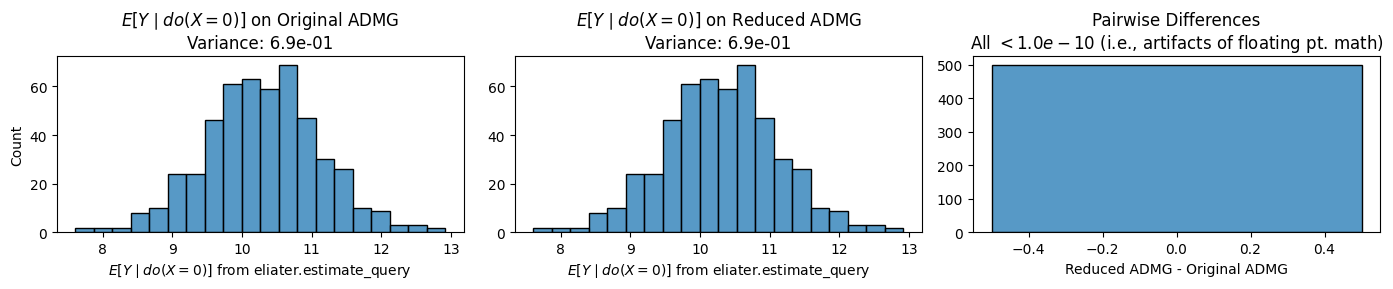

**Caveat**: Eliater does not yet have an automated explanation of what the results of this analysis mean.


In [10]:
eliater.step_5_notebook_synthetic(
    graph=graph, reduced_graph=reduced_graph, example=example, treatment=X, outcome=Y, seed=SEED
)